In [1]:
#Histopathological Cancer Detection Project with Data Augmentation and Sample Data

# Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import pickle

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, datasets

2025-07-21 17:06:24.019908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753117584.241315      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753117584.305522      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## View Data, Distributions, and images

In [3]:
train = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [4]:
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
train.isnull().sum().to_frame().T

,id,label
0,0,0


In [6]:
(train.label.value_counts()/len(train)).to_frame()

,count
label,
0,0.594969
1,0.405031


In [7]:
train['filenames'] = train['id']+'.tif'

In [8]:
train.head()

,id,label,filenames
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


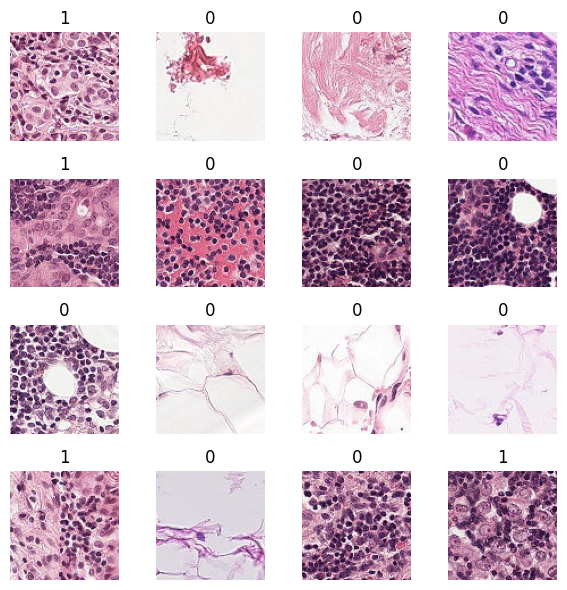

In [9]:
train_images_path = '/kaggle/input/histopathologic-cancer-detection/train'
sample = train.sample(n=16).reset_index()

plt.figure(figsize = (6,6))

for i in range(len(sample)):
    img = mpimg.imread(f'{train_images_path}/{sample.filenames[i]}')
    label = sample.label
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.title(sample.label[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Sample the Data to make training much more efficient

In [10]:
SS = 50000
RS = 10

positives =train[train['label']==1].sample(SS, random_state = RS)
negatives = train[train['label'] == 0].sample(SS, random_state = RS)

new_train = pd.concat([positives, negatives], axis = 0).reset_index(drop=True)
new_train = shuffle(new_train)

In [11]:
new_train.head()

,id,label,filenames
38872,136c5bbe91cb26117101688d595afe3ad454c670,1,136c5bbe91cb26117101688d595afe3ad454c670.tif
63886,d1c12fd8488d98f4487f9710abe1c48b32c4ea05,0,d1c12fd8488d98f4487f9710abe1c48b32c4ea05.tif
18394,c1480832f02888b9d884830b1769839d48bb7c5c,1,c1480832f02888b9d884830b1769839d48bb7c5c.tif
1036,e0130457654fd669009cc6b7093de25f0545c122,1,e0130457654fd669009cc6b7093de25f0545c122.tif
97067,d1d5c0f1722e99181dcb8e7c28e50c52304f5c05,0,d1d5c0f1722e99181dcb8e7c28e50c52304f5c05.tif


In [12]:
(new_train.label.value_counts()/len(new_train)).to_frame().T #this also gives an even distribution of data!

label,1,0
count,0.5,0.5


## Perform Train_test_split

In [13]:
train_df, val_df = train_test_split(new_train, test_size = .2, random_state = 10, stratify = new_train.label)

print(train_df.shape)
print(val_df.shape)

(80000, 3)
(20000, 3)


### Rescale Images with ImageDataGenerator

In [14]:
train_datagen = ImageDataGenerator(rescale = 1/255)
val_datagen = ImageDataGenerator(rescale = 1/255)

Change labels to strings!

In [15]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

## Create loaders using data augmentation 
* (horizontal and vertical flips, rotation, and height and width shifts)
* Images sized to 64x64 to start


In [16]:
%%time
batch_size = 64 #smaller due to smaller dataset

train_loader = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_images_path,
    x_col = 'filenames',
    y_col = 'label',
    batch_size = batch_size,
    seed = 10,
    shuffle = True,
    class_mode = 'binary',
    target_size = (96,96),
    horizontal_flip = True,
    vertical_flip = True,
    height_shift_range = .1,
    width_shift_range  = .1,
    rotation_range = 15
)

val_loader = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = train_images_path,
    x_col = 'filenames',
    y_col = 'label',
    batch_size = batch_size,
    seed = 10,
    shuffle = True,
    class_mode = 'binary',
    target_size = (96,96)
)

Found 80000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.
CPU times: user 2.27 s, sys: 4.29 s, total: 6.56 s
Wall time: 4min 33s


In [17]:
TR_STEPS = len(train_loader)
VAL_STEPS = len(val_loader)

print(TR_STEPS)
print(VAL_STEPS)

1250
313


## Create the Sequential Model with increasing filters and new input shape size

In [18]:
cnn_model_3 = Sequential([
    Conv2D(32, (3,3), activation = 'relu', input_shape = (96,96,3)),
    Conv2D(32, (3,3), activation = 'relu'),
    Conv2D(32, (3,3), activation = 'relu'),

    MaxPooling2D(2,2),
    Dropout(.2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation = 'relu'),
    Conv2D(64, (3,3), activation = 'relu'),
    Conv2D(64, (3,3), activation = 'relu'),

    MaxPooling2D(2,2),
    Dropout(.2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation = 'relu'),
    Conv2D(128, (3,3), activation = 'relu'),
    Conv2D(128, (3,3), activation = 'relu'),

    MaxPooling2D(2,2),
    Dropout(.2),
    BatchNormalization(),

    Flatten(),

    Dense(256, activation = 'relu'),
    Dropout(.2),
    Dense(128, activation = 'relu'),
    Dropout(.2),
    Dense(32, activation = 'relu'),
    Dropout(.2),
    Dense(1, activation = 'sigmoid')

])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753117874.173085      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [19]:
cnn_model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 45, 45, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 39, 39, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 19, 19, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,698,625 (6.48 MB)

 Trainable params: 1,698,177 (6.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [20]:
opt = tf.keras.optimizers.Adam(learning_rate = .001)
cnn_model_3.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['AUC'])

In [21]:
%%time
h1 = cnn_model_3.fit(
    x = train_loader,
    steps_per_epoch = TR_STEPS,
    epochs = 10,
    validation_data = val_loader,
    validation_steps = VAL_STEPS,
    verbose = 1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1753117886.167557      59 service.cc:148] XLA service 0x7918f40067f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753117886.168297      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753117887.149949      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1250 ━━━━━━━━━━━━━━━━━━━━ 7:20:09 21s/step - AUC: 0.5490 - loss: 1.1081

I0000 00:00:1753117898.024308      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 764s 595ms/step - AUC: 0.8377 - loss: 0.5066 - val_AUC: 0.8115 - val_loss: 0.6820
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 152s 121ms/step - AUC: 0.8994 - loss: 0.4037 - val_AUC: 0.7404 - val_loss: 0.9241
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - AUC: 0.9190 - loss: 0.3639 - val_AUC: 0.9023 - val_loss: 0.4171
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 119s 95ms/step - AUC: 0.9264 - loss: 0.3483 - val_AUC: 0.9177 - val_loss: 0.3951
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 123s 98ms/step - AUC: 0.9358 - loss: 0.3259 - val_AUC: 0.9270 - val_loss: 0.6109
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 98ms/step - AUC: 0.9446 - loss: 0.3020 - val_AUC: 0.7758 - val_loss: 0.8802
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 118s 94ms/step - AUC: 0.9509 - loss: 0.2840 - val_AUC: 0.9406 - val_loss: 0.3371
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 121s 97ms/step - AUC: 0.9566 - loss: 0.2671 - val_AUC: 0.9587 - val_loss: 0.3145
Epoch 9/10
1250/1250 ━━━

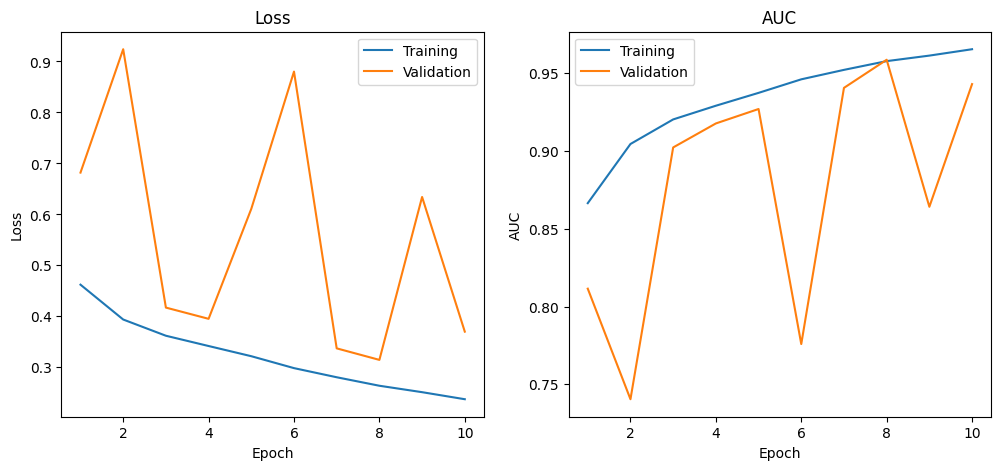

In [22]:
history = h1.history
epoch_range = range(1,len(history['loss'])+1)

plt.figure(figsize = [12,5])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label = 'Training')
plt.plot(epoch_range, history['val_loss'], label = 'Validation')
plt.xlabel('Epoch');plt.ylabel('Loss');plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_range, history['AUC'], label = 'Training')
plt.plot(epoch_range, history['val_AUC'], label = 'Validation')
plt.xlabel('Epoch');plt.ylabel('AUC');plt.title("AUC")
plt.legend()
plt.show()

In [23]:
opt.learning_rate.assign(.0005)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0005000000237487257>

In [24]:
%%time
h2 = cnn_model_3.fit(
    x = train_loader,
    steps_per_epoch = TR_STEPS,
    epochs = 20,
    validation_data = val_loader,
    validation_steps = VAL_STEPS,
    verbose = 1
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 91ms/step - AUC: 0.9733 - loss: 0.2074 - val_AUC: 0.8775 - val_loss: 0.7591
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 116s 92ms/step - AUC: 0.9758 - loss: 0.1963 - val_AUC: 0.9689 - val_loss: 0.2389
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 118s 95ms/step - AUC: 0.9788 - loss: 0.1828 - val_AUC: 0.9582 - val_loss: 0.3028
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 91ms/step - AUC: 0.9803 - loss: 0.1772 - val_AUC: 0.9702 - val_loss: 0.2612
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 92ms/step - AUC: 0.9823 - loss: 0.1679 - val_AUC: 0.9688 - val_loss: 0.2330
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 116s 93ms/step - AUC: 0.9824 - loss: 0.1669 - val_AUC: 0.9700 - val_loss: 0.2697
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 121s 96ms/step - AUC: 0.9845 - loss: 0.1558 - val_AUC: 0.9562 - val_loss: 0.3289
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 118s 95ms/step - AUC: 0.9862 - loss: 0.1475 - val_AUC: 0.9742 - val_loss: 0.2217
Epoch 9/20
1250/

In [25]:
%%time
opt.learning_rate.assign(.0001)
h3 = cnn_model_3.fit(
    x = train_loader,
    steps_per_epoch = TR_STEPS,
    epochs = 15,
    validation_data = val_loader,
    validation_steps = VAL_STEPS,
    verbose = 1
)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 115s 92ms/step - AUC: 0.9970 - loss: 0.0649 - val_AUC: 0.9738 - val_loss: 0.2532
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 115s 92ms/step - AUC: 0.9979 - loss: 0.0518 - val_AUC: 0.9733 - val_loss: 0.2670
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 124s 99ms/step - AUC: 0.9982 - loss: 0.0485 - val_AUC: 0.9699 - val_loss: 0.3100
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - AUC: 0.9982 - loss: 0.0476 - val_AUC: 0.9723 - val_loss: 0.2873
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 121s 97ms/step - AUC: 0.9983 - loss: 0.0438 - val_AUC: 0.9645 - val_loss: 0.3637
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 121s 97ms/step - AUC: 0.9986 - loss: 0.0432 - val_AUC: 0.9673 - val_loss: 0.3431
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 120s 96ms/step - AUC: 0.9984 - loss: 0.0440 - val_AUC: 0.9703 - val_loss: 0.3109
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 119s 95ms/step - AUC: 0.9988 - loss: 0.0396 - val_AUC: 0.9718 - val_loss: 0.2999
Epoch 9/15
1250

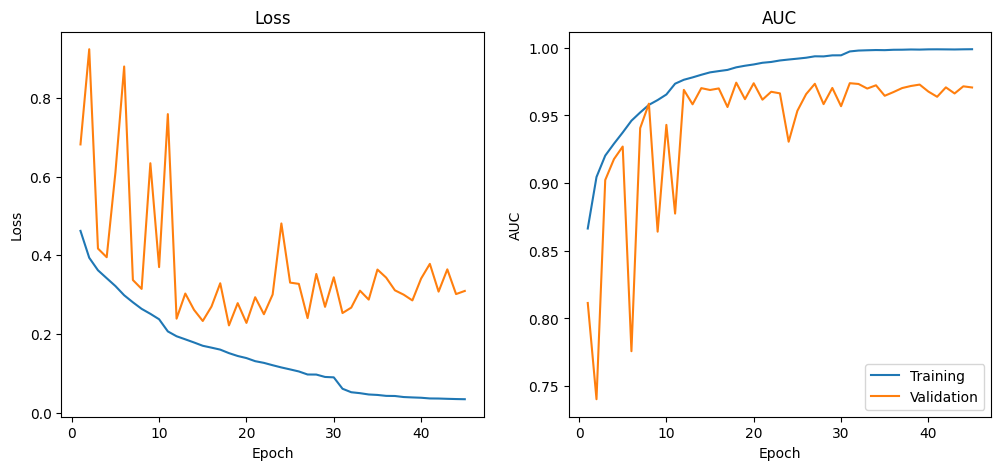

In [26]:
for k in history.keys():
    history[k]+=h2.history[k]
for k in history.keys():
    history[k]+=h3.history[k]

epoch_range = range(1, len(history['loss'])+1)
plt.figure(figsize = [12,5])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label = 'Training')
plt.plot(epoch_range, history['val_loss'], label = 'Validation')
plt.xlabel('Epoch');plt.ylabel('Loss');plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(epoch_range, history['AUC'], label = 'Training')
plt.plot(epoch_range, history['val_AUC'], label = 'Validation')
plt.xlabel("Epoch");plt.ylabel("AUC");plt.title("AUC")
plt.legend()
plt.show()

In [27]:


cnn_model_3.save('Cancer_detection_cnn_model_3.h5')
pickle.dump(history, open(f'Cancer_Detection_model_3.pk1', 'wb'))